In [2]:
import numpy as np

train = np.load('/Users/santoshramesh/Desktop/NASA-BTA-ESTO/data/FloodGNN-GRU/train.npz', allow_pickle=True)['harvey']
val = np.load('/Users/santoshramesh/Desktop/NASA-BTA-ESTO/data/FloodGNN-GRU/val.npz', allow_pickle=True)['harvey']
test = np.load('/Users/santoshramesh/Desktop/NASA-BTA-ESTO/data/FloodGNN-GRU/test.npz', allow_pickle=True)['harvey']
sample = train[0]

In [4]:
static = sample['static']  # shape: (nodes, 3)
static.shape

(1519, 3)

static has two dimensions/axes: number of nodes/grid cells, and three features.

feature 1: DEM of cell
feature 2: Distance of cell to closest stream
feature 3: Manning's coefficient of friction of cell

In [ ]:
sample['s_edges'].shape

s_edges is the edge list of the sample.

In [ ]:
sample['bin'].shape

bin (optional). Binary data for wet versus dry cells. It has three dimensions: number of nodes, time axis, and binary value (0 or 1).

In [5]:
sample['data'].shape

(1519, 132, 8)

data has three dimensions: number of nodes, time axis, and 8 features.

feature 1: water depth
feature 2 & 3: in velocity vector
feature 4 & 5: out velocity vector
feature 6: in velocity norm
feature 7: out velocity norm
feature 8: rainfall

In [7]:
import networkx as nx

G = nx.Graph()
for i, feat in enumerate(static):
    G.add_node(i, elevation=feat[0], dist_to_stream=feat[1], friction=feat[2])
for src, dst in sample['s_edges']:
    G.add_edge(src, dst)

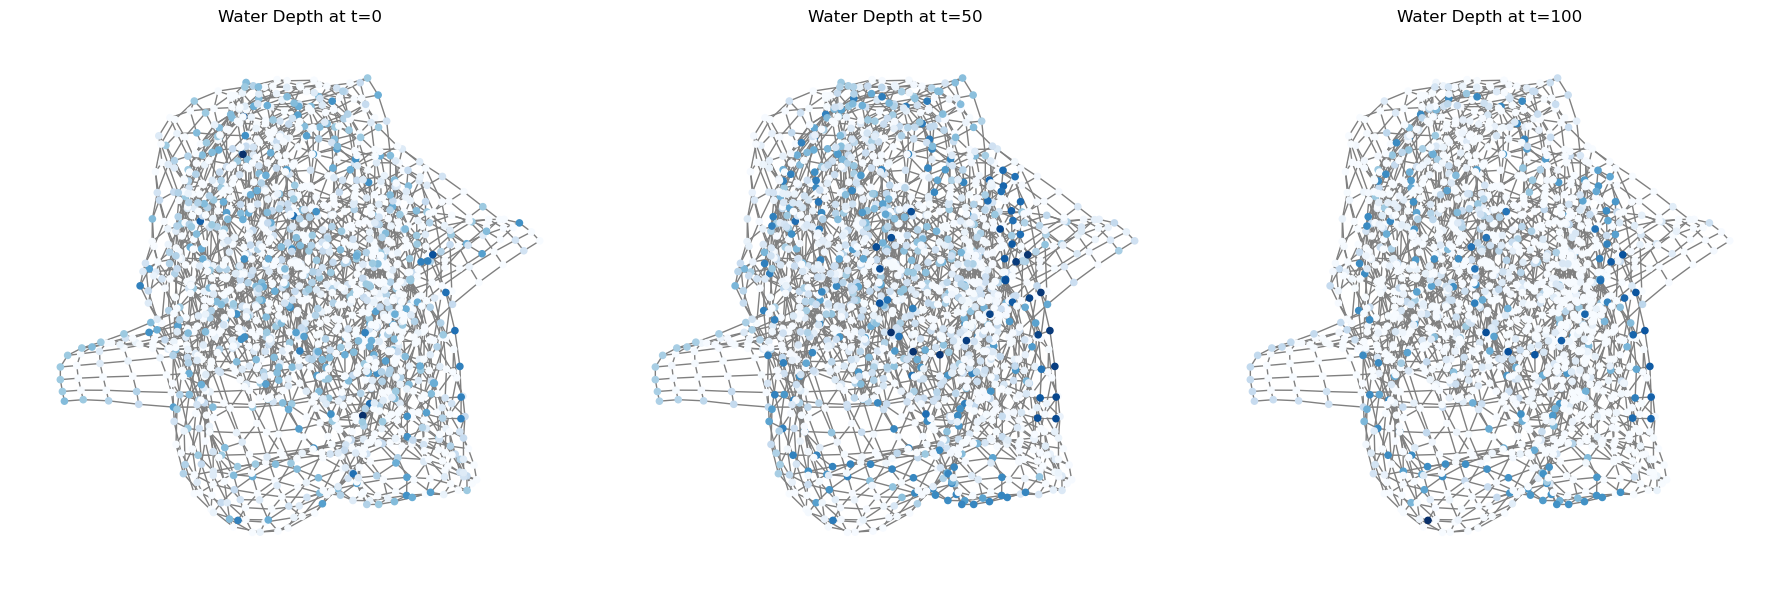

In [8]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G, seed=42)
time_points = [0, 50, 100]

fig, axes = plt.subplots(1, len(time_points), figsize=(18, 6))
water_depth = sample['data'][:, :, 0]  
for idx, t in enumerate(time_points):
    ax = axes[idx]
    wd_t = water_depth[:, t]
    nx.draw(
        G, pos, node_color=wd_t, node_size=20, edge_color='gray',
        cmap=plt.cm.Blues, ax=ax, with_labels=False
    )
    ax.set_title(f"Water Depth at t={t}")

plt.tight_layout()
plt.show()


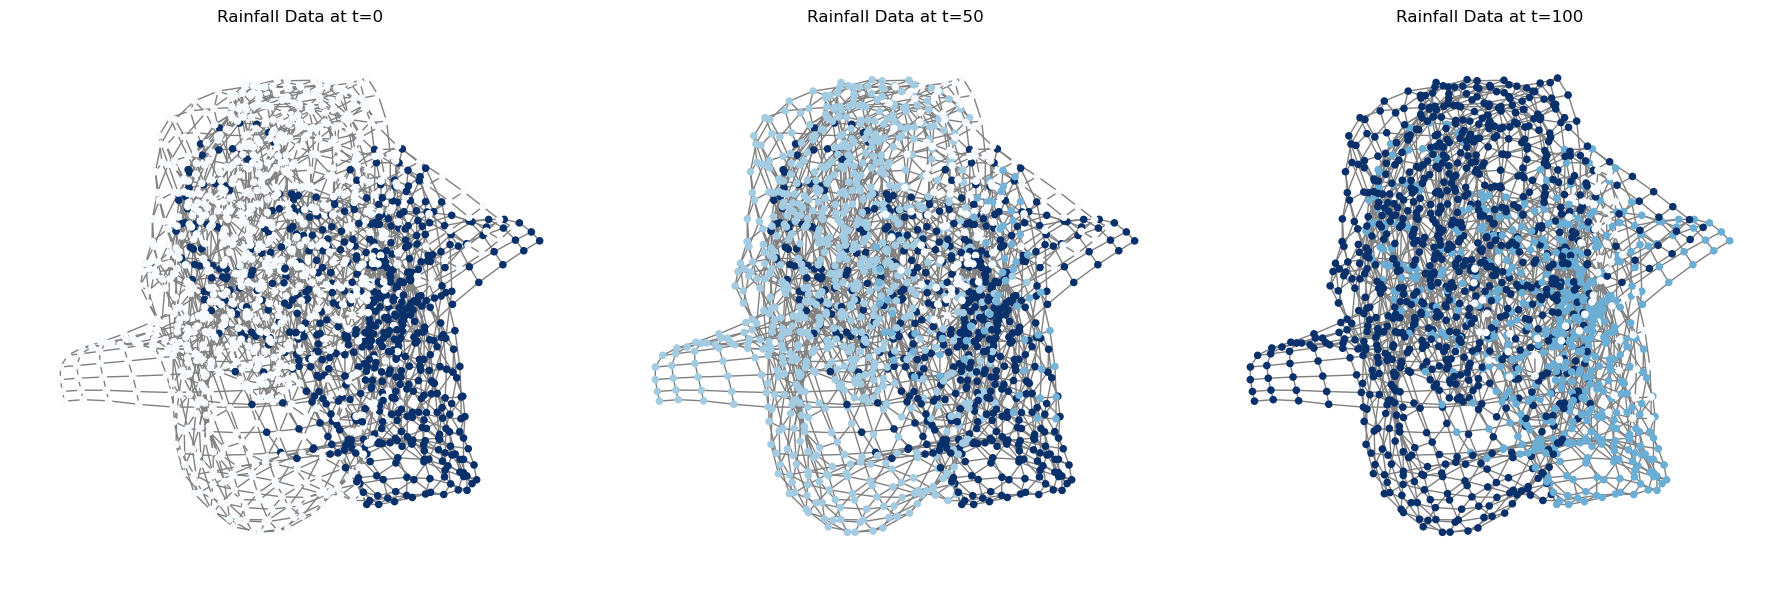

In [6]:
pos = nx.spring_layout(G, seed=42)
time_points = [0, 50, 100]

fig, axes = plt.subplots(1, len(time_points), figsize=(18, 6))
rainfall_data = sample['data'][:, :, 7]  
for idx, t in enumerate(time_points):
    ax = axes[idx]
    wd_t = rainfall_data[:, t]
    nx.draw(
        G, pos, node_color=wd_t, node_size=20, edge_color='gray',
        cmap=plt.cm.Blues, ax=ax, with_labels=False
    )
    ax.set_title(f"Rainfall Data at t={t}")

plt.tight_layout()
plt.show()


In [12]:
import torch
def detect_spikes(rain_tensor, threshold=0.01):
    delta = torch.abs(rain_tensor[:, 1:] - rain_tensor[:, :-1])
    spike_mask = (delta > threshold).squeeze(-1)  # shape: (num_nodes, T-1)
    return spike_mask

# Detect spikes in rainfall
spike_mask = detect_spikes(torch.tensor(rainfall_data, dtype=torch.float32))
print("Spike mask shape:", spike_mask.shape)

Spike mask shape: torch.Size([1519, 131])


In [14]:
def build_qubo_from_graph(G, rainfall_snapshot, elevation_weight=1.0, rainfall_weight=2.0):
    Q = {}
    for i in G.nodes:
        elev = G.nodes[i]['elevation']
        rain = rainfall_snapshot[i].item() if i < len(rainfall_snapshot) else 0
        Q[(i, i)] = elevation_weight * elev - rainfall_weight * rain
    for i, j in G.edges:
        Q[(i, j)] = -1  # Encourage connected flooding
    return Q

# Use last time step rainfall for QUBO
rainfall_snapshot = rainfall_data[:, -1]
qubo = build_qubo_from_graph(G, rainfall_snapshot)
print("QUBO size:", len(qubo))

QUBO size: 4477


In [ ]:
import dimod

bqm = dimod.BinaryQuadraticModel.from_qubo(qubo, offset=0.0)

# Use simulated annealing
sampler = dimod.SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=100)

# Print best result
best_sample = sampleset.first.sample
best_energy = sampleset.first.energy

print("Best solution found:")
print(best_sample)
print(f"Energy: {best_energy}")

Best solution found:
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 1, 131: 1, 132: 1, 133: 1, 134: 1, 135: 1, 